In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pydub import AudioSegment
from scipy.ndimage.morphology import (generate_binary_structure,iterate_structure, binary_erosion)
from scipy.ndimage.filters import maximum_filter

# Maybe for Hash function:

#import operator
#from operator import itemgetter
#import hashlib

In [34]:
sound = AudioSegment.from_mp3(os.getcwd() + "/KJFK-Twr-Apr-19-2017-1030Z.mp3")

# Sample

In [36]:
def get_2D_peaks(arr2D, plot=False, amp_min=10, neighbor = 20):
 
    # amp_min is minimum amplitude in spectrogram in order to be considered a peak. 
    # This can be raised to reduce number of fingerprints, but can negatively affect accuracy.
    
    # neighbor is the number of cells around an amplitude peak in the spectrogram in order
    # for Dejavu to consider it a spectral peak. Higher values mean less
    # fingerprints and faster matching, but can potentially affect accuracy.
    
    # http://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.morphology.iterate_structure.html#scipy.ndimage.morphology.iterate_structure
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, neighbor)

    # find local maxima using our fliter shape
    local_max = maximum_filter(arr2D, footprint=neighborhood) == arr2D
    background = (arr2D == 0)
    eroded_background = binary_erosion(background, structure=neighborhood,
                                       border_value=1)

    # Boolean mask of arr2D with True at peaks
    detected_peaks = local_max - eroded_background

    # extract peaks
    amps = arr2D[detected_peaks]
    j, i = np.where(detected_peaks)

    # filter peaks
    amps = amps.flatten()
    peaks = zip(i, j, amps)
    peaks_filtered = [x for x in peaks if x[2] > amp_min]  # freq, time, amp

    # get indices for frequency and time
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]

    if plot:
        # scatter of the peaks
        fig, ax = plt.subplots()
        ax.imshow(arr2D)
        ax.scatter(time_idx, frequency_idx)
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        ax.set_title("Spectrogram")
        plt.gca().invert_yaxis()
        plt.show()

    return zip(frequency_idx, time_idx)

In [37]:
def VisualizeVoice(sound, start_sec = 0, end_sec = 300, NFFT = 1024, noverlap = 512, amp_min=10, neighbor = 20):
    
    # Get array of sound
    sample_rate = sound.frame_rate
    sound_track = sound.get_array_of_samples()
    sound_length = end_sec - start_sec
    
    # Plot specgram and get pxx, freq, bins, im
    pxx, freqs, bins, _ = plt.specgram(sound_track[int(start_sec * sample_rate): int(end_sec * sample_rate)],
                                   Fs = sample_rate, NFFT = NFFT, noverlap = noverlap,xextent = (start_sec, end_sec))
    plt.clf()
    plt.close('all')
    
    # apply log transform since specgram() returns linear array
    pxx = 10 * np.log10(pxx)
    pxx[pxx == -np.inf] = 0
    
    local_maxima = get_2D_peaks(pxx, plot=False, amp_min=amp_min, neighbor = neighbor)
    local_maxima_freq = np.asarray([item[0] for item in local_maxima])
    local_maxima_time = np.asarray([item[1] for item in local_maxima])
    time_idx = local_maxima_time * sound_length / bins.shape[0] + start_sec
    freq_idx = local_maxima_freq * sample_rate / 2 / freqs.shape[0]
    
    # Plot amplitude, specgram, peaks
    t = np.linspace(start_sec, end_sec, (end_sec - start_sec) * sample_rate)
    plt.figure(figsize=(18,12))
    ax1 = plt.subplot(211)
    ax1.plot(t, sound_track[int(start_sec * sample_rate): int(end_sec * sample_rate)])
    ax1.set_xlabel('Elapsed time since audio starts/sec')
    ax1.set_ylabel('Audio')

    ax2 = plt.subplot(212, sharex = ax1)
    Pxx, Freqs, time_ins, im = ax2.specgram(sound_track[int(start_sec * sample_rate): int(end_sec * sample_rate)], 
                                        Fs = sample_rate, NFFT = NFFT, noverlap = noverlap, xextent = (start_sec, end_sec),
                                        mode = 'psd')
    plt.colorbar(im, orientation='horizontal')
    ax2.scatter(time_idx, freq_idx, s =10, marker = '.')
    
    ax2.set_xlabel('Elapsed time since audio starts/sec')
    ax2.set_ylabel('Frequency (Hz)')
#     ax3 = plt.subplot(313, sharex = ax1)
    plt.show()
    
    return Pxx, Freqs, time_ins, im

/Users/dl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/Users/dl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


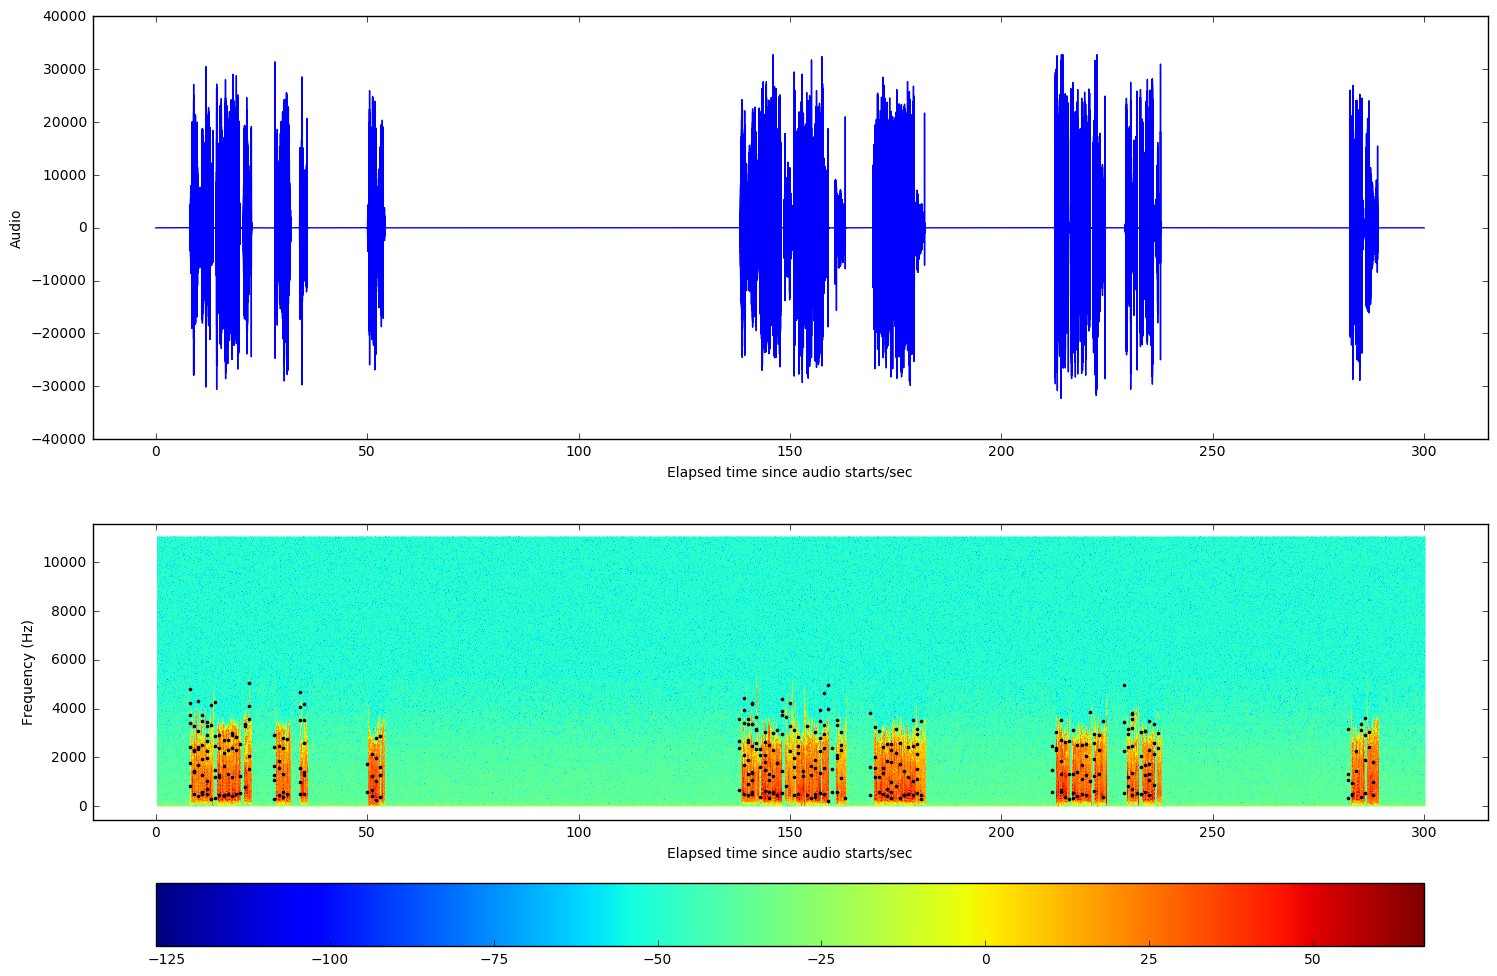

In [38]:
pxx, freqs, bins, im = VisualizeVoice(sound)

# Full

In [39]:
def fingerprint(sound, NFFT = 1024, noverlap = 512, amp_min=10, neighbor = 20):
    
    # Get array of sound
    sample_rate = sound.frame_rate
    sound_track = sound.get_array_of_samples()
    sound_length = sound.duration_seconds
    
    # Plot specgram and get pxx, freq, bins, im
    pxx, freqs, bins, _ = plt.specgram(sound_track, Fs = sample_rate, NFFT = NFFT, noverlap = noverlap)
    plt.clf()
    plt.close('all')
    
    # apply log transform since specgram() returns linear array
    pxx = 10 * np.log10(pxx)
    pxx[pxx == -np.inf] = 0
    
    # Return a 2D list (freqs, time_bins)
    return get_2D_peaks(pxx, plot=False, amp_min=amp_min, neighbor=neighbor)

In [40]:
peaks = fingerprint(sound)

/Users/dl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/dl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
